# MFCC & Scattering Transform Comparaison

## Utils

In [1]:
import sys
sys.path.append('../')

import torch
from dataset import SpeechCommandsData,MfccTransform,Scattering
from models import EncDecBaseModel
from kymatio.torch import Scattering1D
import umap
import pathlib
import umap.plot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report
from IPython.display import display_html
%matplotlib inline

2023-05-17 11:03:54.521481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def speech_commands_collate(batch):
    """Collate function for setting up the dataloader

    Args:
        batch (int): batch size

    Returns:
        batch: return batched data in the form ; audio_tensor,target,task_label
    """
    tensors, targets, t_labels = [], [], []
    for waveform, label, rate, sid, uid in batch:
        if isinstance(waveform,np.ndarray):
            tensors += [torch.from_numpy(waveform)]
        elif isinstance(waveform, torch.Tensor):
            tensors += [waveform]
        else:
            raise ValueError("Waveform must be saved as torch.tensor or np.array")
        targets += [torch.tensor(label)]

    tensors = [item.t() for item in tensors]
    tensors = torch.nn.utils.rnn.pad_sequence(
        tensors, batch_first=True, padding_value=0.0
    )
    
    targets = torch.stack(targets)

    return tensors, targets

In [3]:
def predict(model,input):
    return torch.nn.functional.softmax(model(input),dim=-1).squeeze().argmax(dim=-1)

In [25]:
@torch.no_grad()
def extract_logits_preds(model, dataloader):
  preds_buffer = []
  logits_buffer = []
  label_buffer = []

  for batch in tqdm(dataloader):
    audio_signal, labels = batch
  
    preds_buffer.append(predict(model=model,input=audio_signal))
    logits_buffer.append(model(audio_signal.squeeze()))
    label_buffer.append(labels)
  
  preds = torch.cat(preds_buffer, 0)
  logits = torch.cat(logits_buffer, 0)
  labels = torch.cat(label_buffer, 0)
  return logits, preds, labels

In [5]:
@torch.no_grad()
def count_correct(model,dataloader):
    correct=torch.zeros(35)
    total=torch.zeros(35)
    for batch in tqdm(dataloader):
        audio,labels=batch
        res=torch.eq(predict(model=model,input=audio),labels)
        for it,equality in enumerate(res):
            total[labels[it]]+=1
            if equality:
                correct[labels[it]]+=1
            
    return correct,total

In [6]:
def display_side_by_side(args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

## UMAP

In [32]:
device = torch.device("cpu")

mfcc = MfccTransform(16000)
scattering = Scattering()

mfcc.to(device)
scattering.to(device)

Scattering(
  (scattering): Scattering1D()
  (batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [16]:
labels_names = ["backward","bed","bird","cat","dog","down","eight","five","follow","forward","four","go","happy","house","learn","left","marvin","nine","no","off","on","one","right","seven","sheila","six","stop","three","tree","two","up","visual","wow","yes","zero"]

# Set the path to your dataset
root = pathlib.Path("../../dataset/")

# Load your dataset into PyTorch using the SpeechCommandsData class
train_dataset = SpeechCommandsData(root=root, url="speech_commands_v0.02", download=False, subset="training")
test_dataset = SpeechCommandsData(root=root, url="speech_commands_v0.02", download=False, subset="testing")

# Create PyTorch data loaders for your dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False,collate_fn=speech_commands_collate)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False,collate_fn=speech_commands_collate)

In [26]:
mfcc_logits,_,mfcc_labels=extract_logits_preds(mfcc,test_loader)

100%|██████████| 86/86 [00:35<00:00,  2.44it/s]


In [33]:
scattering_logits,_,scattering_labels=extract_logits_preds(scattering,test_loader)

100%|██████████| 86/86 [03:35<00:00,  2.51s/it]


In [29]:
mfcc_manifold = umap.UMAP().fit(mfcc_logits.flatten(1),mfcc_labels)

In [34]:
scattering_manifold = umap.UMAP().fit(scattering_logits.flatten(1),scattering_labels)

Loading BokehJS ...

<Axes: >

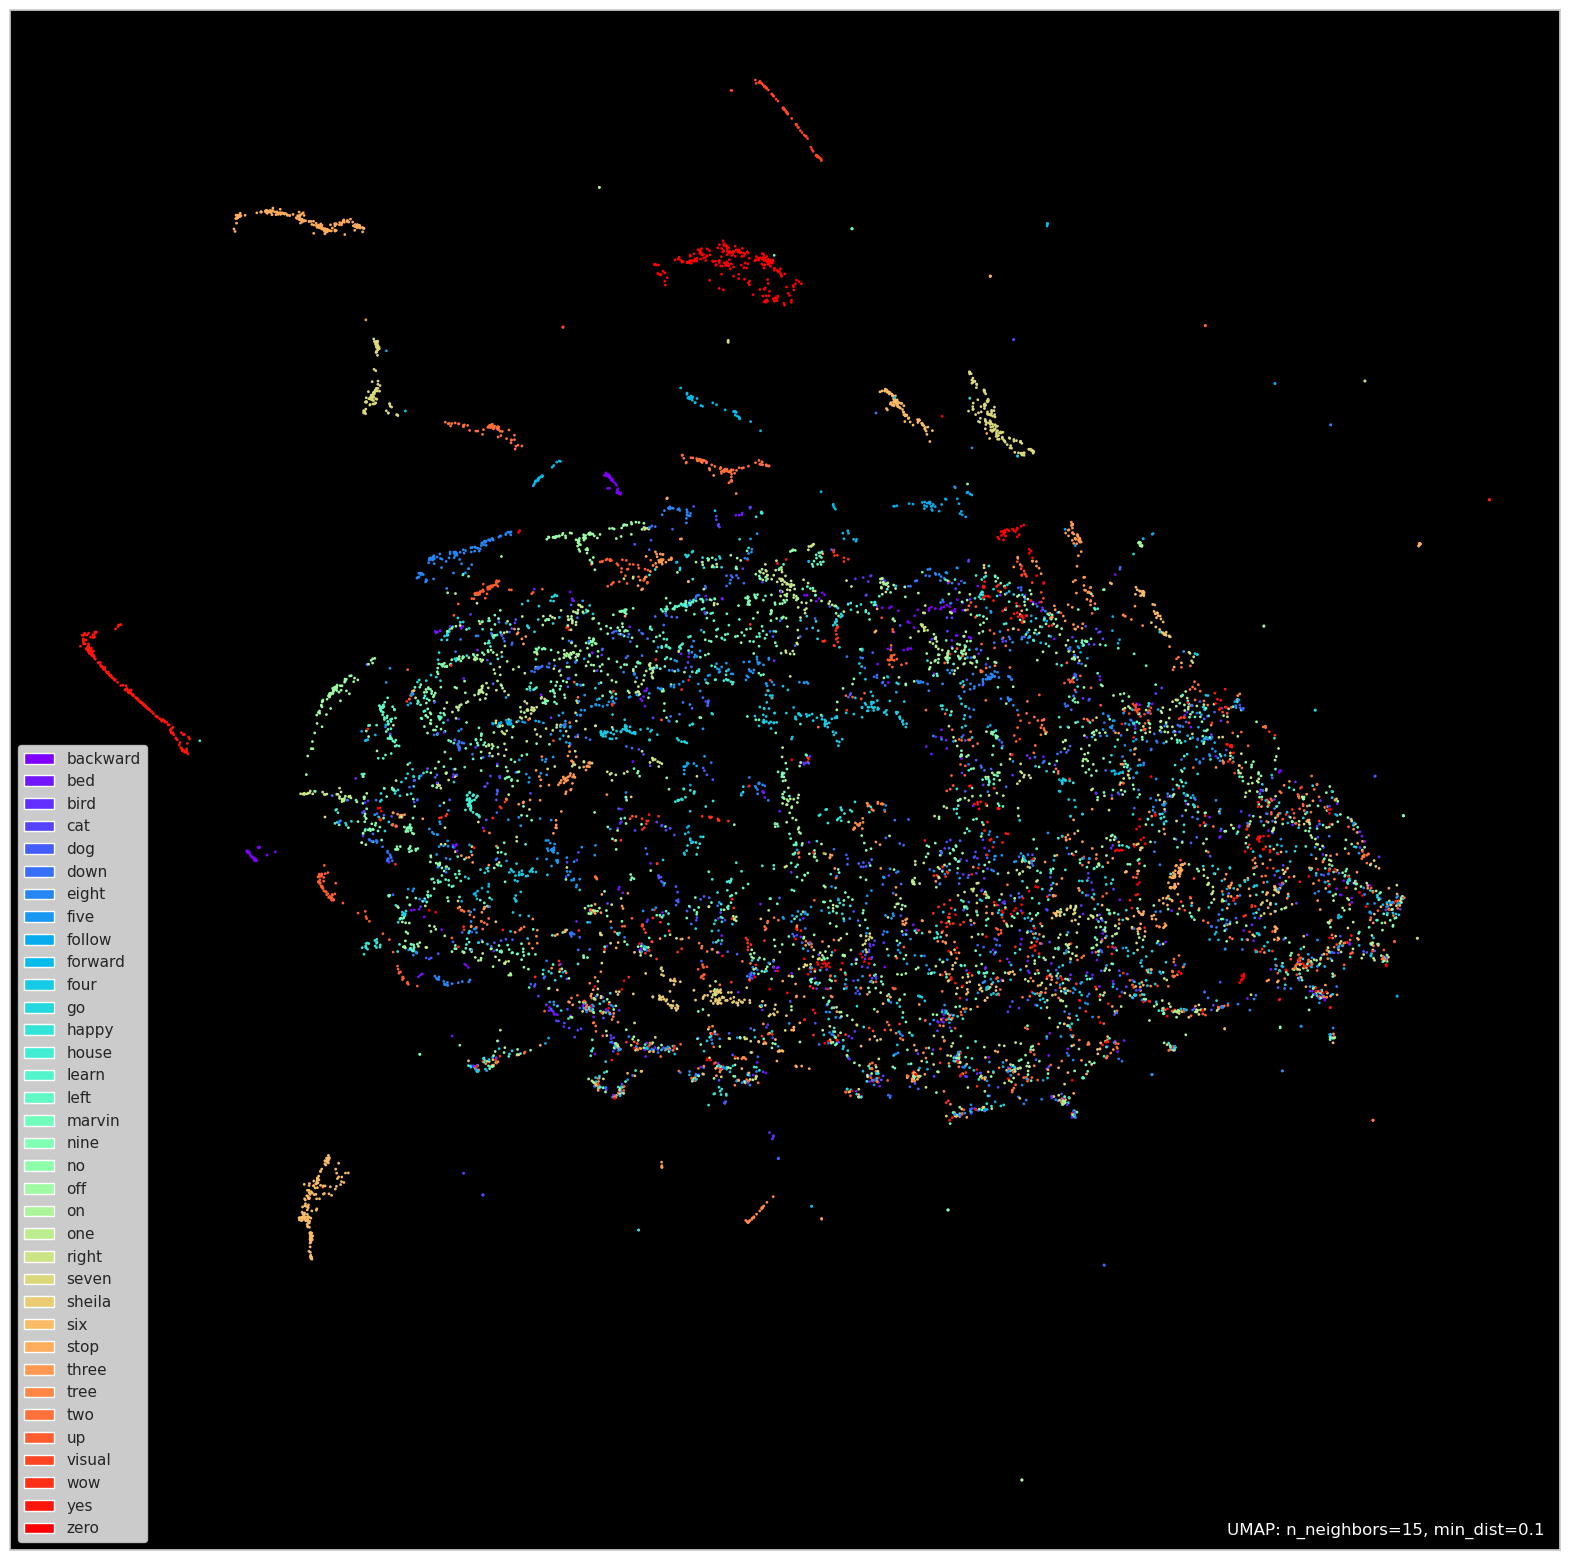

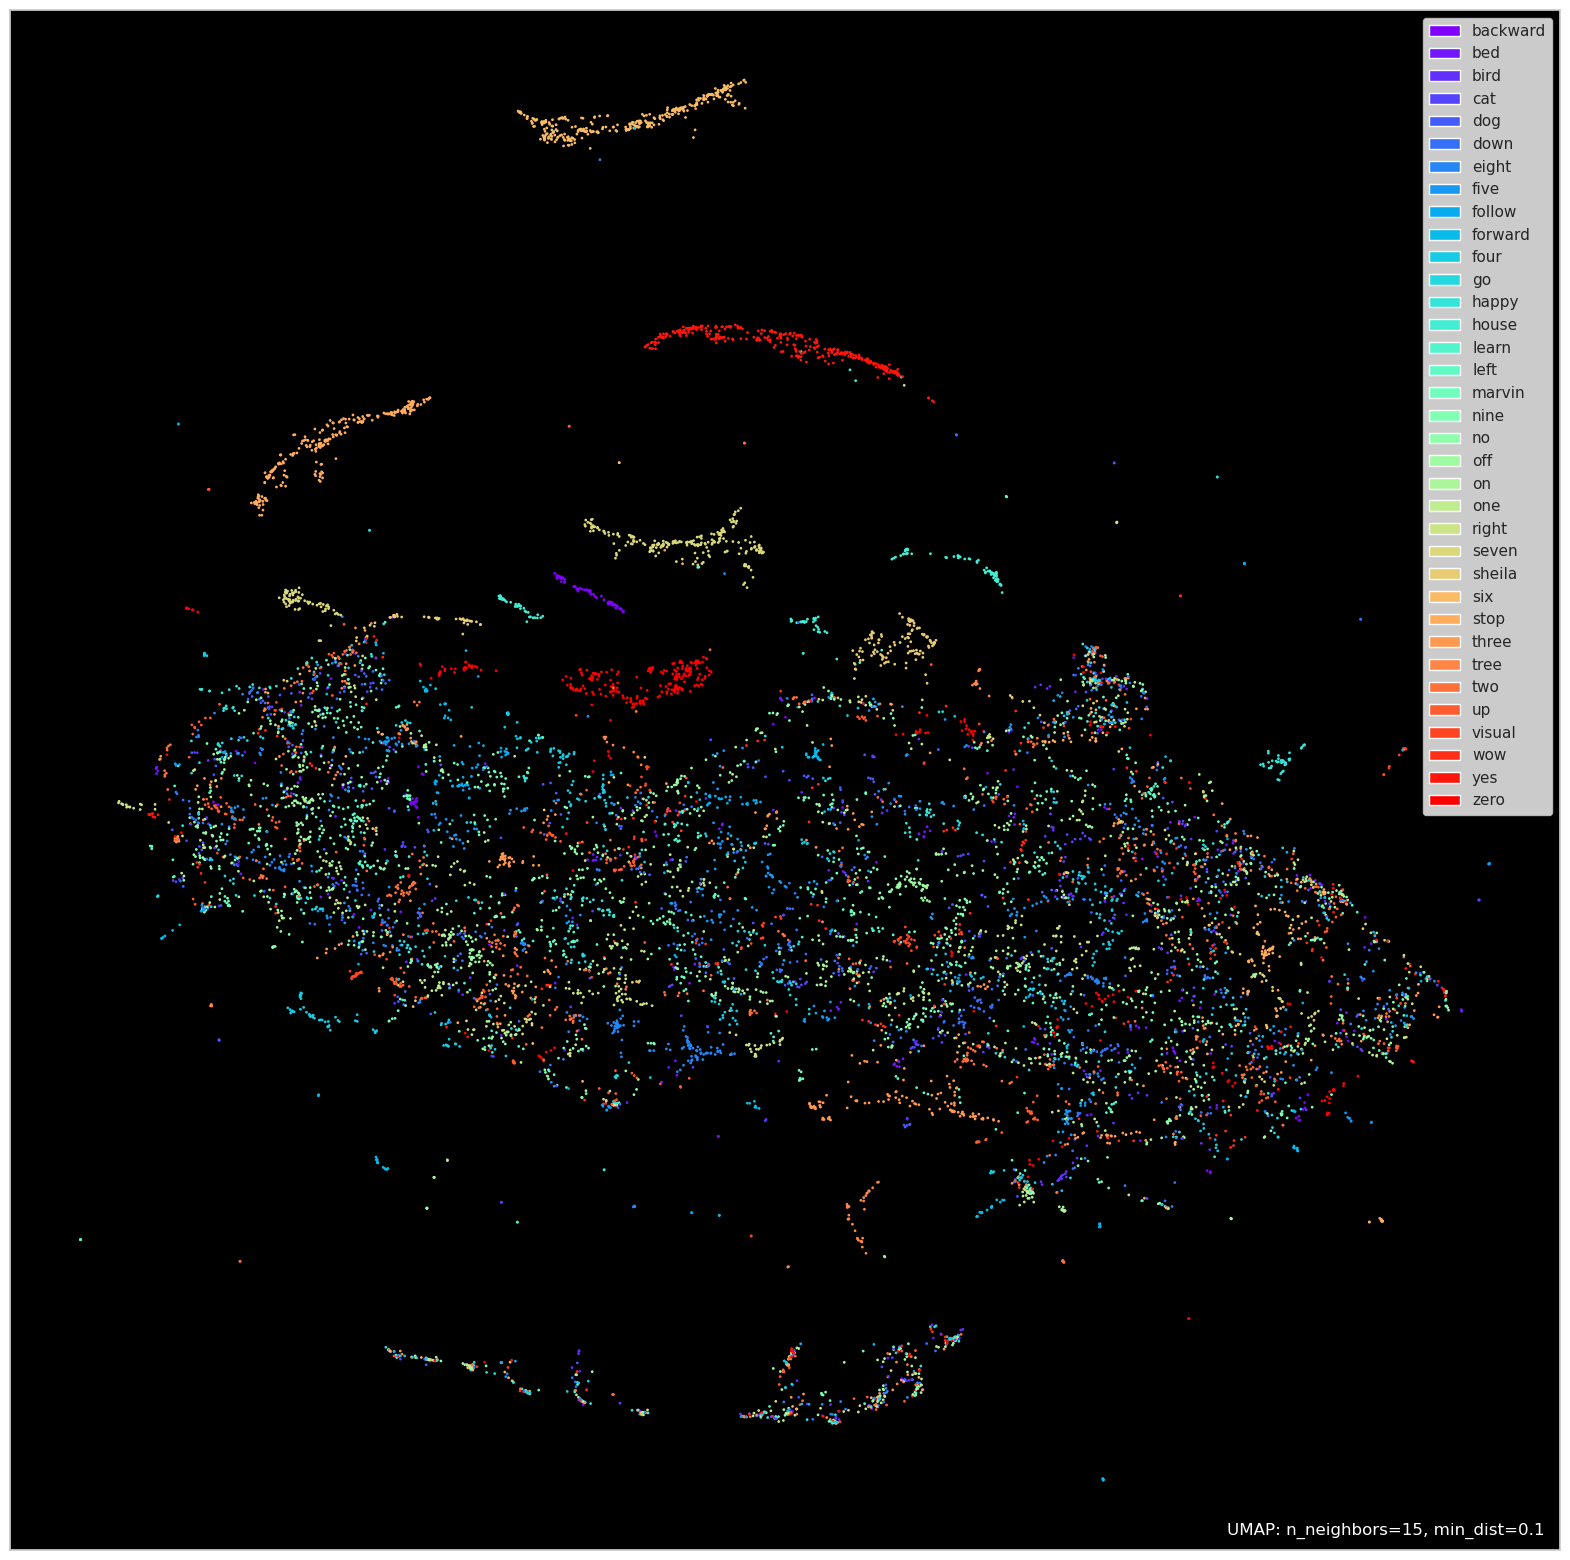

In [36]:
umap.plot.output_notebook()

umap.plot.points(mfcc_manifold, labels=np.array([labels_names[i] for i in mfcc_labels]),width=2000,height=2000,theme="fire")
umap.plot.points(scattering_manifold, labels=np.array([labels_names[i] for i in scattering_labels]),width=2000,height=2000,theme="fire")

## Robustess

We first import the testing male and female datasets

In [7]:
device = torch.device("cpu")

# Set the path to your dataset
root = pathlib.Path("../../dataset/")

# Load your dataset into PyTorch using the SpeechCommandsData class
male_test_dataset = SpeechCommandsData(root=root, url="MaleCommands", download=False, subset="training")
female_test_dataset = SpeechCommandsData(root=root, url="FemaleCommands", download=False, subset="training")

# Create PyTorch data loaders for your dataset
male_test_loader = torch.utils.data.DataLoader(male_test_dataset, batch_size=128, shuffle=False,collate_fn=speech_commands_collate)
female_test_loader = torch.utils.data.DataLoader(female_test_dataset, batch_size=128, shuffle=False,collate_fn=speech_commands_collate)

We then load the pretrained models

In [8]:
scat_male_model=torch.nn.Sequential( Scattering(),EncDecBaseModel(num_mels=50,num_classes=35,final_filter=128,input_length=1000))
mfcc_male_model=EncDecBaseModel(num_mels=64,num_classes=35,final_filter=128,input_length=1601)

scat_female_model=torch.nn.Sequential( Scattering(),EncDecBaseModel(num_mels=50,num_classes=35,final_filter=128,input_length=1000))
mfcc_female_model=EncDecBaseModel(num_mels=64,num_classes=35,final_filter=128,input_length=1601)

In [9]:
scat_male_path   ='./models/scat_male.pt'
scat_female_path ='./models/scat_female.pt'
mfcc_male_path   ='./models/mfcc_male.pt'
mfcc_female_path ='./models/mfcc_female.pt'

scat_male_model.load_state_dict(torch.load(scat_male_path))
scat_female_model.load_state_dict(torch.load(scat_female_path))
mfcc_male_model.load_state_dict(torch.load(mfcc_male_path))
mfcc_female_model.load_state_dict(torch.load(mfcc_female_path))


mfcc_male_model=torch.nn.Sequential(MfccTransform(sample_rate=16000),mfcc_male_model)
mfcc_female_model=torch.nn.Sequential(MfccTransform(sample_rate=16000),mfcc_female_model)

mfcc_male_model.to(device=device)
mfcc_female_model.to(device=device)
scat_male_model.to(device=device)
scat_female_model.to(device=device)

mfcc_male_model.eval()
mfcc_female_model.eval()
scat_male_model.eval()
scat_female_model.eval()

Sequential(
  (0): Scattering(
    (scattering): Scattering1D()
    (batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): EncDecBaseModel(
    (encoder): ConvASREncoder(
      (conv_block_1): ConvBlock(
        (mconv): ModuleList(
          (0): Conv1d(50, 50, kernel_size=(11,), stride=(1,), padding=(5,), groups=50, bias=False)
          (1): Conv1d(50, 128, kernel_size=(1,), stride=(1,), bias=False)
          (2): BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (mout): Sequential(
          (0): ReLU(inplace=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (conv_res_block_1): ConvBlock(
        (mconv): ModuleList(
          (0): Conv1d(128, 128, kernel_size=(13,), stride=(1,), padding=(6,), groups=128, bias=False)
          (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,), bias=False)
          (2): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, tra

Now we cross test the models

In [10]:
mfcc_fom,m_total=count_correct(model=mfcc_female_model,dataloader=male_test_loader)
mfcc_mof,w_total=count_correct(model=mfcc_male_model,dataloader=female_test_loader)
scat_fom,_      =count_correct(model=scat_female_model,dataloader=male_test_loader)
scat_mof,_      =count_correct(model=scat_male_model,dataloader=female_test_loader)

100%|██████████| 190/190 [05:31<00:00,  1.75s/it]


And we plot our results

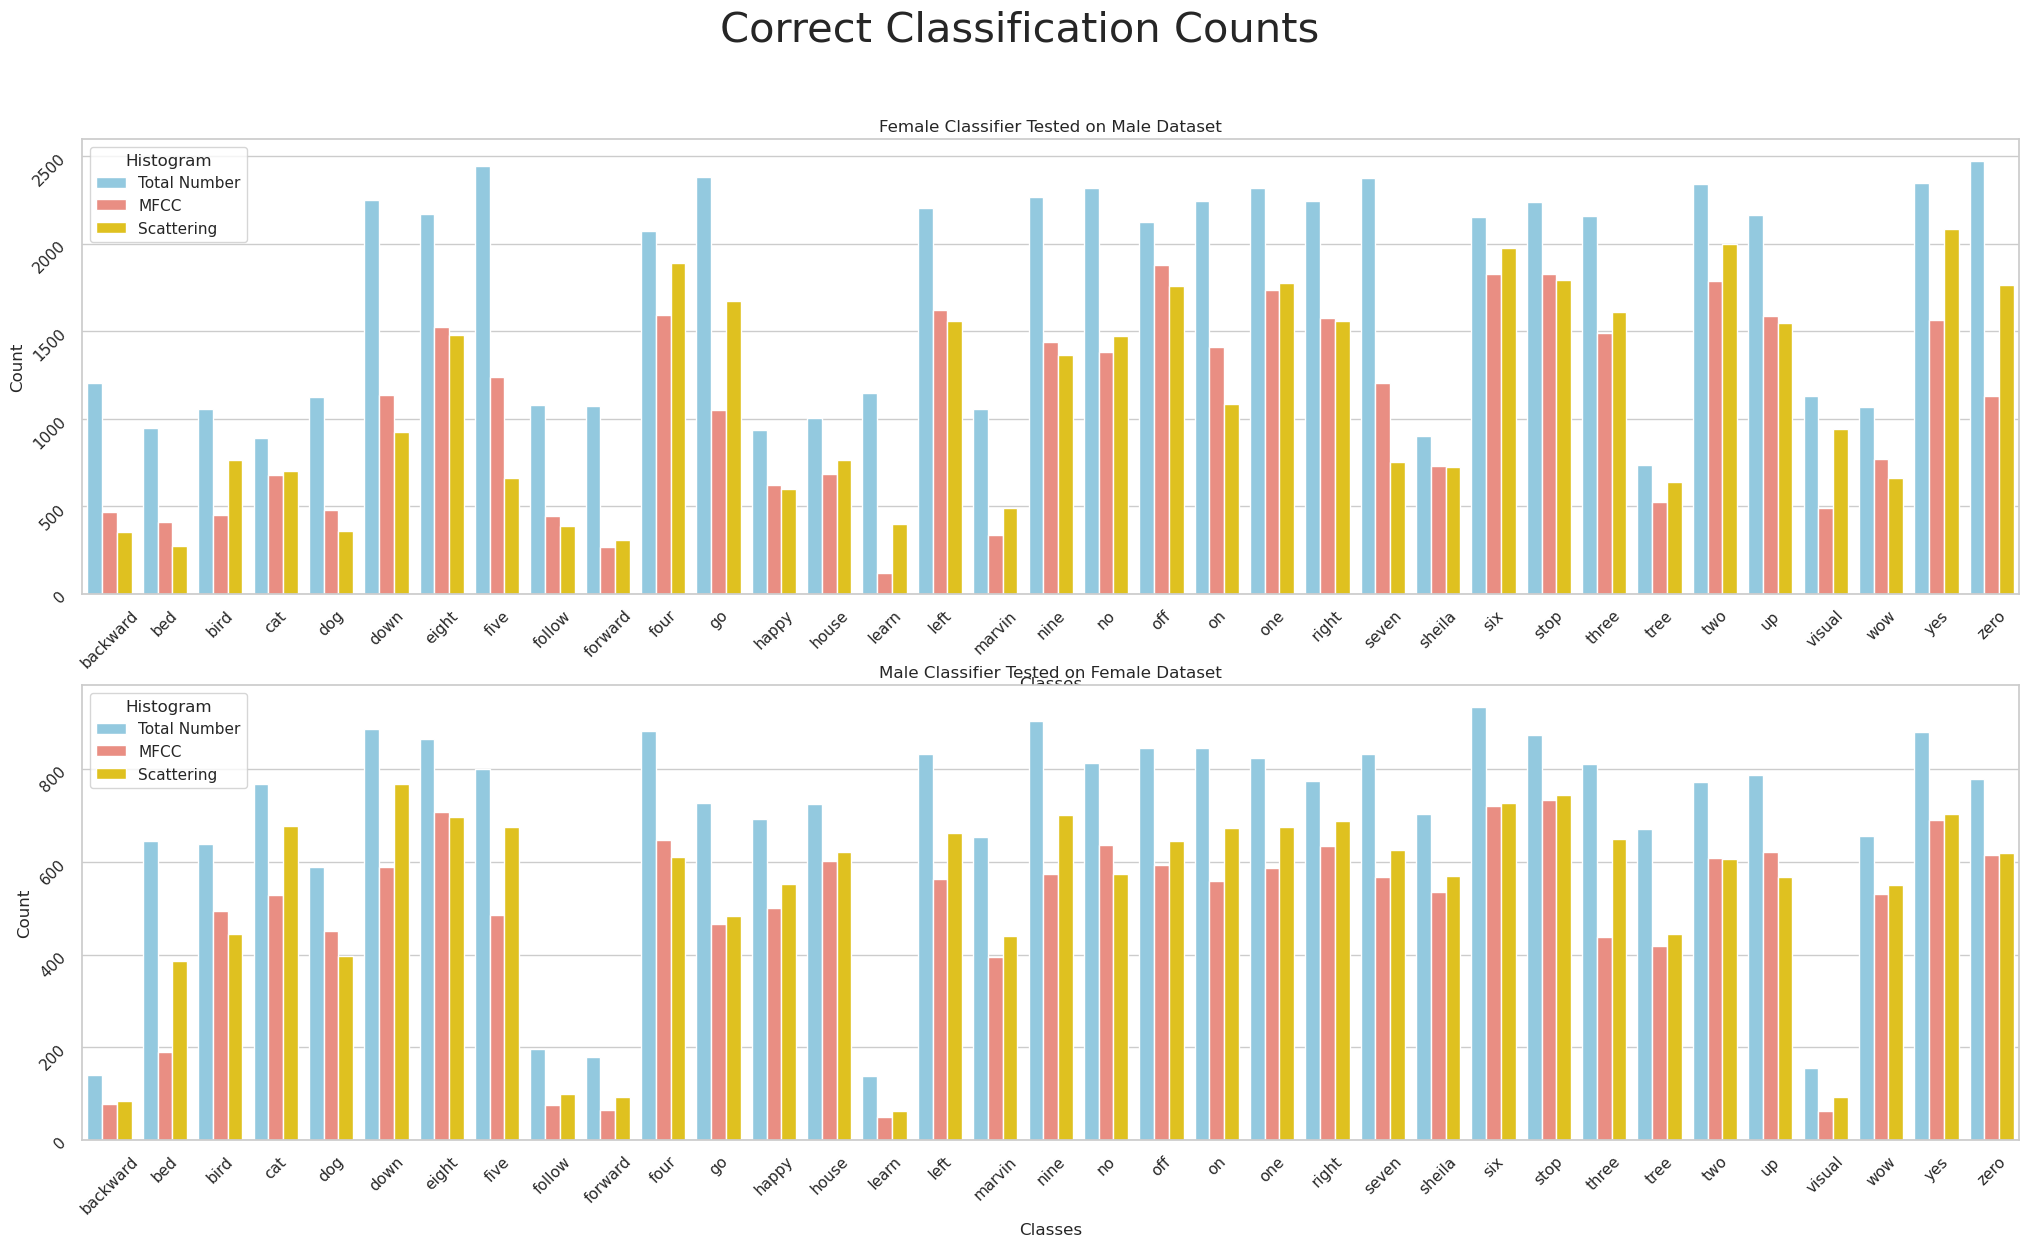

In [11]:
classes = ["backward","bed","bird","cat","dog","down","eight","five","follow","forward","four","go","happy","house","learn","left","marvin","nine","no","off","on","one","right","seven","sheila","six","stop","three","tree","two","up","visual","wow","yes","zero"]

# Set up Seaborn style
sns.set(style="whitegrid")

# Combine classes and counts into a DataFrame
data1 = pd.DataFrame({"Classes": classes, "Total Number": m_total, "MFCC": mfcc_fom, "Scattering": scat_fom})
data2 = pd.DataFrame({"Classes": classes, "Total Number": w_total, "MFCC": mfcc_mof, "Scattering": scat_mof})

# Melt the DataFrame to combine the counts into a single column
melted_data1 = data1.melt(id_vars=["Classes"], var_name="Histogram", value_name="Counts")
melted_data2 = data2.melt(id_vars=["Classes"], var_name="Histogram", value_name="Counts")

# Create a figure and axis
fig, (ax1,ax2) = plt.subplots(2,figsize=(25,13))

# Generate the grouped bar plot
sns.barplot(x="Classes", y="Counts", ax=ax1, hue="Histogram", data=melted_data1, palette=["skyblue", "salmon", "gold"])
sns.barplot(x="Classes", y="Counts", ax=ax2, hue="Histogram", data=melted_data2, palette=["skyblue", "salmon", "gold"])

# Set labels and title
ax1.set_xlabel("Classes")
ax1.set_ylabel("Count")
ax1.set_title("Female Classifier Tested on Male Dataset")
ax1.tick_params(labelrotation=45)
ax2.set_xlabel("Classes")
ax2.set_ylabel("Count")
ax2.set_title("Male Classifier Tested on Female Dataset")
ax2.tick_params(labelrotation=45)

fig.suptitle("Correct Classification Counts",fontsize=30)

# Show the plot
plt.show()

We give out a classification report for each experience

In [12]:
_,preds_mfcc_fom,m_labels=extract_logits_preds(model=mfcc_female_model,dataloader=male_test_loader)
_,preds_mfcc_mof,w_labels=extract_logits_preds(model=mfcc_male_model,dataloader=female_test_loader)
_,preds_scat_fom,_       =extract_logits_preds(model=scat_female_model,dataloader=male_test_loader)
_,preds_scat_mof,_       =extract_logits_preds(model=scat_male_model,dataloader=female_test_loader)

100%|██████████| 190/190 [04:40<00:00,  1.48s/it]


In [14]:
report_mfcc_fom = classification_report(preds_mfcc_fom, m_labels, target_names=classes, output_dict=True)
report_mfcc_mof = classification_report(preds_mfcc_mof, w_labels, target_names=classes, output_dict=True)
report_scat_fom = classification_report(preds_scat_fom, m_labels, target_names=classes, output_dict=True)
report_scat_mof = classification_report(preds_scat_mof, w_labels, target_names=classes, output_dict=True)


metrics = ['precision', 'recall', 'f1-score']

result_data = {}
for metric in metrics:
    result_data[metric] = {
        'MFCC_fom': [report_mfcc_fom[class_name][metric] for class_name in classes],
        'SCAT_fom': [report_scat_fom[class_name][metric] for class_name in classes],
        'MFCC_mof': [report_mfcc_mof[class_name][metric] for class_name in classes],
        'SCAT_mof': [report_scat_mof[class_name][metric] for class_name in classes]
    }

accuracies = {
    'MFCC_fom': report_mfcc_fom['accuracy'],
    'SCAT_fom': report_scat_fom['accuracy'],
    'MFCC_mof': report_mfcc_mof['accuracy'],
    'SCAT_mof': report_scat_mof['accuracy']
}

result_data['accuracy'] = accuracies

# Create separate DataFrames for each metric
dfs = {}
for metric in metrics:
    dfs[metric] = pd.DataFrame(result_data[metric], index=classes)


print("Metric: Accuracy")
display(pd.DataFrame(result_data['accuracy'],index=['accuracy']))
print("\n")

print("Pandas dfs for: ",end='')
print(*dfs.keys(), sep = ", ")

display_side_by_side(dfs.values())

Metric: Accuracy


,MFCC_fom,SCAT_fom,MFCC_mof,SCAT_mof
accuracy,0.618186,0.645021,0.702321,0.768151




Pandas dfs for: precision, recall, f1-score


,MFCC_fom,SCAT_fom,MFCC_mof,SCAT_mof
backward,0.388382,0.294606,0.546099,0.595745
bed,0.433087,0.290832,0.296124,0.598450
bird,0.428706,0.725212,0.774295,0.695925
cat,0.763780,0.791901,0.688802,0.882812
dog,0.427427,0.319679,0.765306,0.675170
down,0.504673,0.412550,0.664036,0.865840
eight,0.702952,0.682657,0.818497,0.804624
five,0.506557,0.271311,0.606250,0.845000
follow,0.414272,0.359592,0.387755,0.510204
forward,0.251859,0.288104,0.366667,0.511111
